In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'
REGION = "us-central1"

# VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com'
VERTEX_SA = 'jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")
print(f"REGION: {REGION}")
print(f"VERTEX_SA: {VERTEX_SA}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1
REGION: us-central1
VERTEX_SA: jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com


In [2]:
REGION = 'us-central1'
EXPERIMENT = 'causal_impact_v1'
SERIES = 'causal_v1'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

BQ_SOURCE1 = 'bigquery-public-data.new_york.citibike_trips'
BQ_SOURCE2 = 'bigquery-public-data.new_york.citibike_stations'
viz_limit = 9

### time series config

In [3]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 7
forecast_test_length = 150
forecast_val_length = 31

CONTROL_GROUP='control_group'

TREATMENT_DATE='2016-05-04'

### packages

In [4]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

import seaborn as sns

from google.cloud import aiplatform as vertex_ai


In [5]:
bq_client = bigquery.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID, 
    location=REGION,
    # credentials=credentials
)

## create BQ Dataset

In [6]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us' #REGION
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq_client.create_dataset(dataset = ds, exists_ok = True)

In [7]:
ds.dataset_id

'causal_v1'

In [8]:
ds.full_dataset_id

'hybrid-vertex:causal_v1'

In [9]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE1}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,640,2016-08-07 06:46:42+00:00,2016-08-07 06:57:22+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,3102,Driggs Ave & Lorimer St,40.721791,-73.950415,25387,Subscriber,1972,male
1,1835,2015-11-22 13:37:13+00:00,2015-11-22 14:07:48+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,305,E 58 St & 3 Ave,40.760958,-73.967245,19401,Customer,<NA>,unknown
2,964,2016-06-08 07:24:06+00:00,2016-06-08 07:40:11+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,282,Kent Ave & S 11 St,40.707645,-73.968415,17311,Subscriber,1970,male
3,985,2016-05-05 07:20:22+00:00,2016-05-05 07:36:48+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,282,Kent Ave & S 11 St,40.707645,-73.968415,22057,Subscriber,1970,male
4,2124,2016-06-11 12:07:19+00:00,2016-06-11 12:42:43+00:00,3122,48 Ave & 5 St,40.744363,-73.955873,168,W 18 St & 6 Ave,40.739713,-73.994564,14738,Subscriber,1990,male


In [10]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE2}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,495,W 47 St & 10 Ave,6824.07,40.762699,-73.993012,71,"KEY, CREDITCARD",0,False,0,0,0,0,True,True,True,False,1970-01-02 00:00:00+00:00
1,3171,Amsterdam Ave & W 82 St,7360.10,40.785247,-73.976673,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
2,3603,31 Ave & 30 St,6857.09,40.764700,-73.924031,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
3,3733,Avenue C & E 18 St,5769.04,40.730563,-73.973984,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
4,3792,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,70,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00


In [13]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

# station="Pershing Square"
station="Lafayette"

# for demo purposes, inflate response variable 
INFLATED_TARGET='num_trips_jt'

In [14]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender,
        FROM `{BQ_SOURCE1}`
        WHERE start_station_name LIKE '%{station}%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `{BQ_SOURCE2}`
        WHERE name LIKE '%{station}%'
        GROUP BY name
    )
SELECT * EXCEPT(name, ratio_gender, capacity),
    IFNULL(ratio_gender, 0) AS ratio_gender,
    IFNULL(capacity, 0) AS capacity,
    CASE
        WHEN {TIME_COLUMN} BETWEEN '2016-05-04' AND '2016-05-30' THEN {TARGET_COLUMN} + 15
        WHEN {TIME_COLUMN} BETWEEN '2016-05-30' AND '2016-06-30' THEN {TARGET_COLUMN} + 45
        WHEN {TIME_COLUMN} BETWEEN '2016-06-30' AND '2016-07-30' THEN {TARGET_COLUMN} + 75
        WHEN {TIME_COLUMN} BETWEEN '2016-07-30' AND '2016-08-30' THEN {TARGET_COLUMN} + 120
        WHEN {TIME_COLUMN} BETWEEN '2016-08-30' AND '2016-09-30' THEN {TARGET_COLUMN} + 145
        ELSE {TARGET_COLUMN}
    END as {INFLATED_TARGET}
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
WHERE starttime >= date('2013-12-21') 
ORDER BY start_station_name, starttime
"""
job = bq_client.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

1.902

In [15]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, 
        sum({TARGET_COLUMN}) as {TARGET_COLUMN},
        sum({INFLATED_TARGET}) as {INFLATED_TARGET},
        min({TIME_COLUMN}) as FromDate, 
        max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq_client.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,num_trips,num_trips_jt,FromDate,ToDate
0,Clermont Ave & Lafayette Ave,17397,29662,2013-12-21,2016-09-30
1,Cumberland St & Lafayette Ave,23698,35528,2013-12-21,2016-09-27
2,Lafayette Ave & Classon Ave,17010,29275,2013-12-21,2016-09-30
3,Lafayette Ave & Fort Greene Pl,24189,36454,2013-12-21,2016-09-30
4,Lafayette Ave & St James Pl,17430,29695,2013-12-21,2016-09-30
5,Lafayette St & E 8 St,231417,235152,2013-12-21,2016-08-22
6,Lafayette St & Jersey St,142686,149221,2013-12-21,2016-09-30
7,Lafayette St & Jersey St N,4249,5674,2016-07-01,2016-07-19
8,Marcy Ave & Lafayette Ave,2433,14698,2015-08-25,2016-09-30


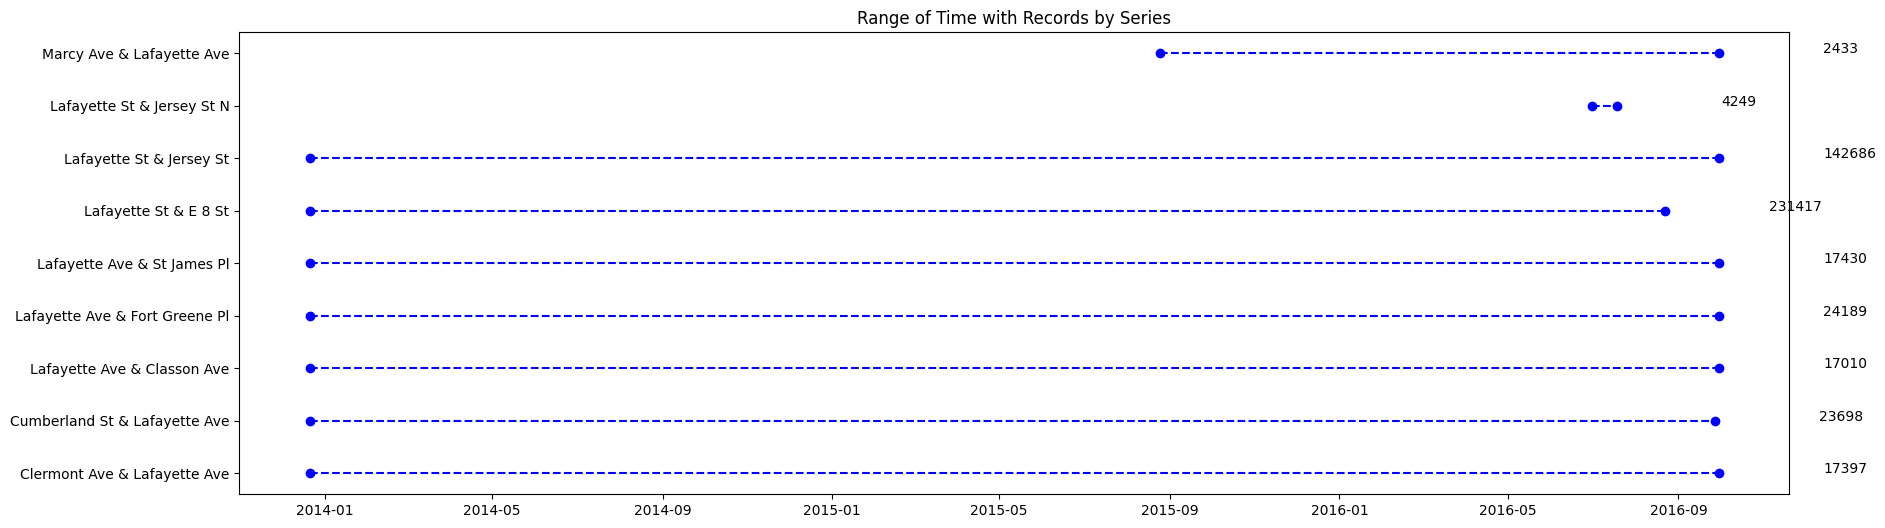

In [16]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

In [17]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq_client.query(query).to_dataframe()

In [18]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date,
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq_client.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-12-21,2016-04-03,2016-05-04,2016-09-30


In [19]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS splits,
       CASE
           WHEN {TIME_COLUMN} BETWEEN '2016-05-04' AND '2016-09-30' THEN 1
           ELSE 0
       END as {CONTROL_GROUP}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq_client.query(query)
job.result()
(job.ended-job.started).total_seconds()

# WHERE date BETWEEN '12/11/2021' AND '20/11/2021'

1.764

In [20]:
query = f"""
SELECT {CONTROL_GROUP}, count(*) as Count, 100*count(*) / (sum(count(*)) OVER()) as Percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
GROUP BY {CONTROL_GROUP}
"""
bq_client.query(query = query).to_dataframe()

,control_group,Count,Percentage
0,0,6209,85.148108
1,1,1083,14.851892


In [21]:
import numpy as np

query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN},{INFLATED_TARGET},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries_v1 = bq_client.query(query).to_dataframe()

# Set dates as index
rawSeries_v1.set_index(TIME_COLUMN, inplace=True)

rawSeries_v1.head(3)

,start_station_name,num_trips,num_trips_jt,avg_tripduration,pct_subscriber,ratio_gender,capacity
starttime,,,,,,,
2013-12-21,Clermont Ave & Lafayette Ave,19,19,685.105263,0.947368,3.75,51
2013-12-22,Clermont Ave & Lafayette Ave,12,12,652.750000,0.916667,1.40,51
2013-12-23,Clermont Ave & Lafayette Ave,4,4,885.750000,1.000000,3.00,51


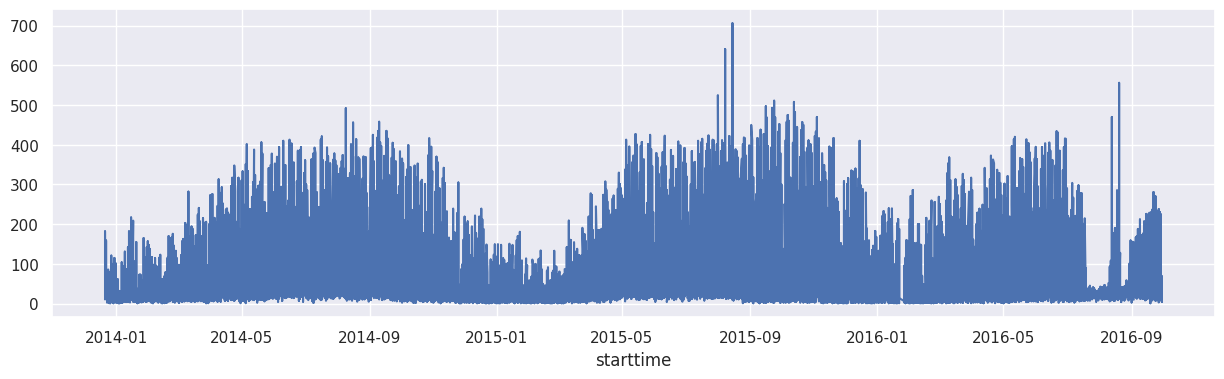

In [22]:
from matplotlib import pyplot
sns.set(rc={'figure.figsize':(15,4)})

rawSeries_v1[TARGET_COLUMN].plot()
pyplot.show()

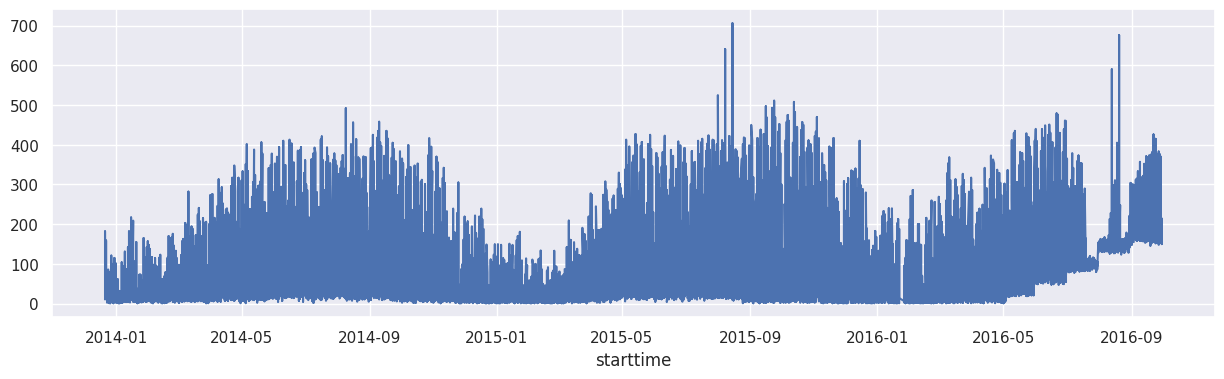

In [23]:
rawSeries_v1[INFLATED_TARGET].plot()
pyplot.show()

In [24]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, 
        sum({TARGET_COLUMN}) as {TARGET_COLUMN},
        sum({INFLATED_TARGET}) as {INFLATED_TARGET},
        min({TIME_COLUMN}) as FromDate,
        max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq_client.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,num_trips,num_trips_jt,FromDate,ToDate
0,Clermont Ave & Lafayette Ave,17397,29662,2013-12-21,2016-09-30
1,Cumberland St & Lafayette Ave,23698,35528,2013-12-21,2016-09-27
2,Lafayette Ave & Classon Ave,17010,29275,2013-12-21,2016-09-30
3,Lafayette Ave & Fort Greene Pl,24189,36454,2013-12-21,2016-09-30
4,Lafayette Ave & St James Pl,17430,29695,2013-12-21,2016-09-30
5,Lafayette St & E 8 St,231417,235152,2013-12-21,2016-08-22
6,Lafayette St & Jersey St,142686,149221,2013-12-21,2016-09-30
7,Lafayette St & Jersey St N,4249,5674,2016-07-01,2016-07-19
8,Marcy Ave & Lafayette Ave,2433,14698,2015-08-25,2016-09-30


## independent, but correlated time series

**Stability** 
* this assumption of `CasualImpact` assumes that the relationship between covariates and treated time series, as established during the pre-period, would have remained stable throughout the post-period if the intervention had not taken place.

similar but related time series
* Austin bike rentals
* not affected by the treatment (of offering a promo to NYC bike rentals)
* but they are correlated with our time series 

In [25]:
BQ_SOURCE3='bigquery-public-data.austin_bikeshare.bikeshare_trips'
BQ_SOURCE4='bigquery-public-data.austin_bikeshare.bikeshare_stations'

BQ_TABLE_AUSTIN='austin_bikes'

query = f"""
    SELECT * 
    FROM `{BQ_SOURCE3}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,trip_id,subscriber_type,bikeid,start_time,start_station_id,start_station_name,end_station_id,end_station_name,duration_minutes
0,9900285908,Annual Membership (Austin B-cycle),400,2014-10-26 14:12:00+00:00,2823,Capital Metro HQ - East 5th at Broadway,2544,East 6th & Pedernales St.,10
1,9900289692,Walk Up,248,2015-10-02 21:12:01+00:00,1006,Zilker Park West,1008,Nueces @ 3rd,39
2,9900285987,24-Hour Kiosk (Austin B-cycle),446,2014-10-26 15:12:00+00:00,2712,Toomey Rd @ South Lamar,2712,Toomey Rd @ South Lamar,31
3,9900285989,24-Hour Kiosk (Austin B-cycle),203,2014-10-26 15:12:00+00:00,2712,Toomey Rd @ South Lamar,2712,Toomey Rd @ South Lamar,31
4,9900285991,24-Hour Kiosk (Austin B-cycle),101,2014-10-26 15:12:00+00:00,2712,Toomey Rd @ South Lamar,2712,Toomey Rd @ South Lamar,30


In [26]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE4}`
    LIMIT 5
"""
bq_client.query(query).to_dataframe()

,station_id,name,status,address,alternate_name,city_asset_number,property_type,number_of_docks,power_type,footprint_length,footprint_width,notes,council_district,modified_date
0,2541,State Capitol @ 14th & Colorado,closed,206 W. 14th St.,None,<NA>,None,<NA>,None,<NA>,NaN,None,1,2021-01-04 12:00:00+00:00
1,2538,Bullock Museum @ Congress & MLK,closed,1881 Congress Ave.,None,<NA>,None,<NA>,None,<NA>,NaN,None,1,2021-01-04 12:00:00+00:00
2,2545,ACC - Rio Grande & 12th,closed,700 W. 12th St.,None,<NA>,None,<NA>,None,<NA>,NaN,None,9,2021-01-04 12:00:00+00:00
3,2546,ACC - West & 12th Street,closed,1231 West Ave.,None,<NA>,None,<NA>,None,<NA>,NaN,None,9,2021-01-04 12:00:00+00:00
4,2564,5th & San Marcos,closed,991 East 5th,None,<NA>,None,<NA>,None,<NA>,NaN,None,3,2021-01-04 12:00:00+00:00


In [27]:
SUBSCRIBER_VALUE='Annual Membership (Austin B-cycle)'

AUSTIN_STATION = '21st & Speedway @PCL'

In [28]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_AUSTIN}_source` AS
WITH
    STATION AS (
        SELECT
           TRIM(start_station_name) AS start_station_name,
           EXTRACT(DATE FROM start_time) AS starttime,
           COUNT(*) AS num_trips,
           AVG(duration_minutes) as avg_tripduration,
        FROM `{BQ_SOURCE3}`
        GROUP BY start_station_name, starttime
    )
SELECT * FROM STATION A
WHERE starttime <= date('2016-09-30')
ORDER BY starttime, start_station_name
"""
job = bq_client.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

2.803

In [29]:
query = f"""
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_AUSTIN}_source`
    ORDER by start_station_name, starttime
"""
rawSeries_v2 = bq_client.query(query).to_dataframe()

rawSeries_v2.set_index(TIME_COLUMN, inplace=True)

rawSeries_v2.head(3)

,start_station_name,num_trips,avg_tripduration
starttime,,,
2015-08-12,11th & San Jacinto,1,7.0
2015-08-13,11th & San Jacinto,5,19.6
2015-08-14,11th & San Jacinto,2,10.0


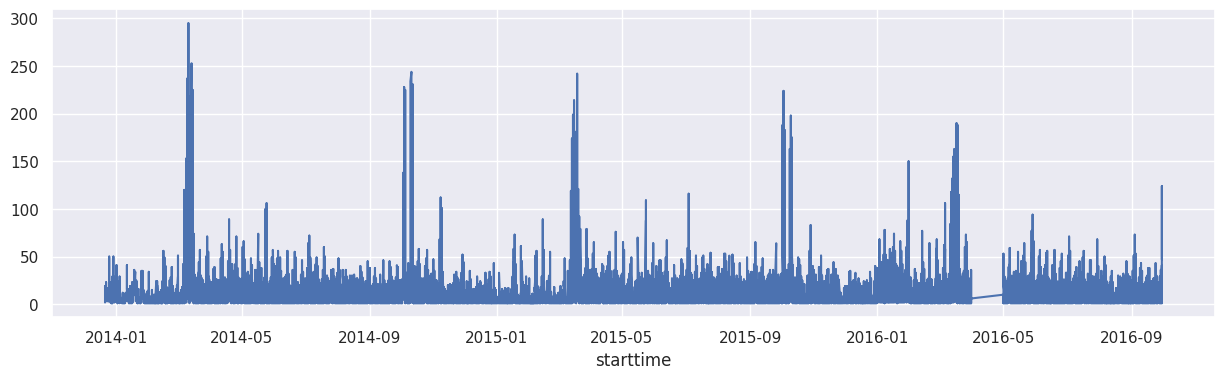

In [30]:
rawSeries_v2['num_trips'].plot()
pyplot.show()

In [31]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, 
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}, 
        min({TIME_COLUMN}) as FromDate, 
        max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_AUSTIN}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview_v2 = bq_client.query(query).to_dataframe()
overview_v2.head(viz_limit)

,start_station_name,num_trips,FromDate,ToDate
0,11th & San Jacinto,1735,2015-08-12,2016-09-30
1,17th & Guadalupe,5994,2014-01-30,2016-09-30
2,2nd & Congress,19894,2013-12-21,2016-09-30
3,3rd & West,10925,2014-02-05,2016-09-30
4,4th & Congress,19758,2013-12-21,2016-09-30
5,5th & Bowie,21225,2013-12-21,2016-09-30
6,5th & San Marcos,6080,2014-02-28,2016-09-30
7,6th & Navasota St.,1301,2014-01-29,2014-06-30
8,8th & Congress,10841,2013-12-21,2016-09-30


### check for duplicates

In [32]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_AUSTIN}_source`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq_client.query(query).to_dataframe()

,start_station_name,starttime,records


### validate key dates

In [33]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date,
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_AUSTIN}_source`  
"""
keyDates_austin = bq_client.query(query).to_dataframe()
keyDates_austin

,start_date,val_start,test_start,end_date
0,2013-12-21,2016-04-03,2016-05-04,2016-09-30


In [34]:
# check these match with our timeseries dates
keyDates

,start_date,val_start,test_start,end_date
0,2013-12-21,2016-04-03,2016-05-04,2016-09-30


In [36]:
query = f"""
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_AUSTIN}_source`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries_austin_1 = bq_client.query(query).to_dataframe()

rawSeries_austin_1.start_station_name = rawSeries_austin_1.start_station_name.str.strip()

In [37]:
AUSTIN_STATION='2nd & Congress'
# AUSTIN_STATION='11th & San Jacinto'

rawSeries_austin_2 = rawSeries_austin_1.loc[rawSeries_austin_1['start_station_name'] == AUSTIN_STATION]
rawSeries_austin_2

,start_station_name,starttime,num_trips,avg_tripduration
1252,2nd & Congress,2013-12-21,9,17.777778
1253,2nd & Congress,2013-12-22,13,15.692308
1254,2nd & Congress,2013-12-23,6,21.333333
1255,2nd & Congress,2013-12-24,5,67.600000
1256,2nd & Congress,2013-12-25,9,65.555556
...,...,...,...,...
2223,2nd & Congress,2016-09-26,9,19.444444
2224,2nd & Congress,2016-09-27,8,11.000000
2225,2nd & Congress,2016-09-28,24,31.958333
2226,2nd & Congress,2016-09-29,22,18.772727


In [38]:
from datetime import datetime

TREATMENT_DATE_obj = datetime.strptime(TREATMENT_DATE, '%Y-%m-%d').date()

rawSeries_austin_2.reset_index(inplace=True)

rawSeries_austin_2.loc[rawSeries_austin_2['starttime'] == TREATMENT_DATE_obj]

,index,start_station_name,starttime,num_trips,avg_tripduration
826,2078,2nd & Congress,2016-05-04,21,14.809524


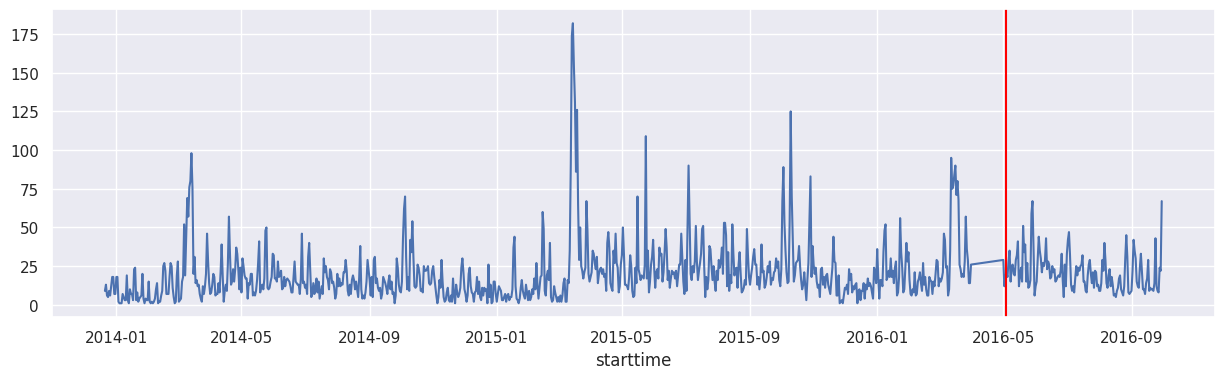

In [39]:
rawSeries_austin_2.set_index(TIME_COLUMN, inplace=True)
rawSeries_austin_2['num_trips'].plot()
plt.axvline(x=rawSeries_austin_2.index[826], color='red')
pyplot.show()

## Review splits and control groups

In [40]:
TREATMENT_STATUS='treatment'

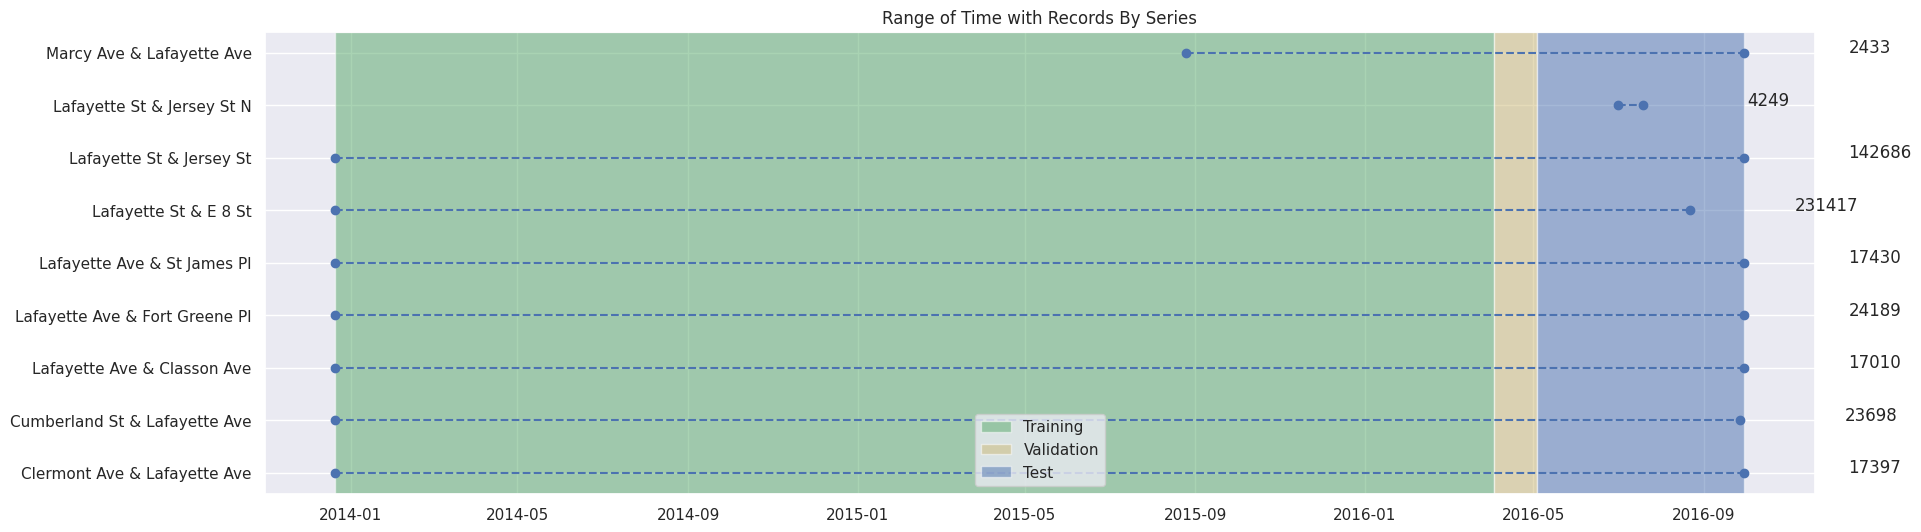

In [41]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

In [42]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        COUNTIF({CONTROL_GROUP}=0) as no_treatment,
        COUNTIF({CONTROL_GROUP}=1) as treatment,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN},
        sum({INFLATED_TARGET}) as {INFLATED_TARGET}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq_client.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,no_treatment,treatment,num_trips,num_trips_jt
0,Clermont Ave & Lafayette Ave,825,31,150,856,150,17397,29662
1,Cumberland St & Lafayette Ave,827,31,147,858,147,23698,35528
2,Lafayette Ave & Classon Ave,818,31,150,849,150,17010,29275
3,Lafayette Ave & Fort Greene Pl,827,31,150,858,150,24189,36454
4,Lafayette Ave & St James Pl,817,31,150,848,150,17430,29695
5,Lafayette St & E 8 St,830,31,76,861,76,231417,235152
6,Lafayette St & Jersey St,813,31,91,844,91,142686,149221
7,Lafayette St & Jersey St N,0,0,19,0,19,4249,5674
8,Marcy Ave & Lafayette Ave,205,30,150,235,150,2433,14698


In [43]:
query = f"""
SELECT splits, count(*) as Count, 100*count(*) / (sum(count(*)) OVER()) as Percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
GROUP BY splits
"""
bq_client.query(query = query).to_dataframe()

,splits,Count,Percentage
0,VALIDATE,247,3.387274
1,TRAIN,5962,81.760834
2,TEST,1083,14.851892


In [44]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       5962
VALIDATE     247
TEST        1083
dtype: int64

## Review time series data

### NYC trips

In [45]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, 
        {TIME_COLUMN}, 
        {TARGET_COLUMN},
        {INFLATED_TARGET},
        splits,
        {CONTROL_GROUP},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq_client.query(query).to_dataframe()

In [46]:
rawSeries

,start_station_name,starttime,num_trips,num_trips_jt,splits,control_group,avg_tripduration,pct_subscriber,ratio_gender,capacity
0,Clermont Ave & Lafayette Ave,2013-12-21,19,19,TRAIN,0,685.105263,0.947368,3.750000,51
1,Clermont Ave & Lafayette Ave,2013-12-22,12,12,TRAIN,0,652.750000,0.916667,1.400000,51
2,Clermont Ave & Lafayette Ave,2013-12-23,4,4,TRAIN,0,885.750000,1.000000,3.000000,51
3,Clermont Ave & Lafayette Ave,2013-12-24,7,7,TRAIN,0,433.714286,1.000000,2.500000,51
4,Clermont Ave & Lafayette Ave,2013-12-25,2,2,TRAIN,0,774.000000,1.000000,0.000000,51
...,...,...,...,...,...,...,...,...,...,...
7287,Marcy Ave & Lafayette Ave,2016-09-26,9,154,TEST,1,1119.666667,1.000000,8.000000,23
7288,Marcy Ave & Lafayette Ave,2016-09-27,14,159,TEST,1,1127.928571,1.000000,0.750000,23
7289,Marcy Ave & Lafayette Ave,2016-09-28,11,156,TEST,1,1089.272727,1.000000,2.666667,23
7290,Marcy Ave & Lafayette Ave,2016-09-29,9,154,TEST,1,1229.333333,0.777778,1.250000,23


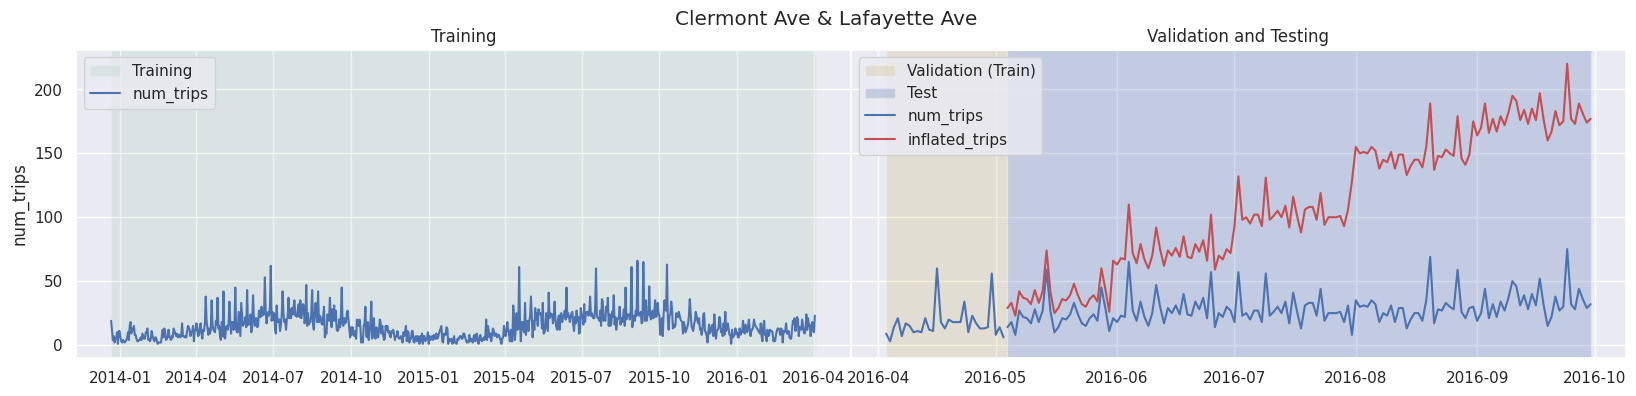

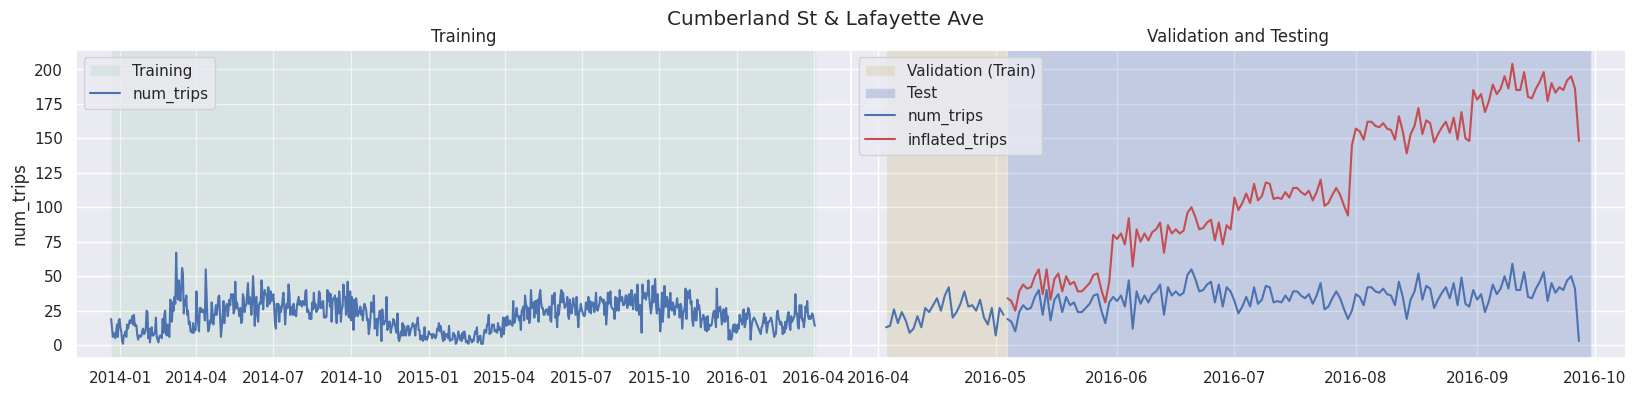

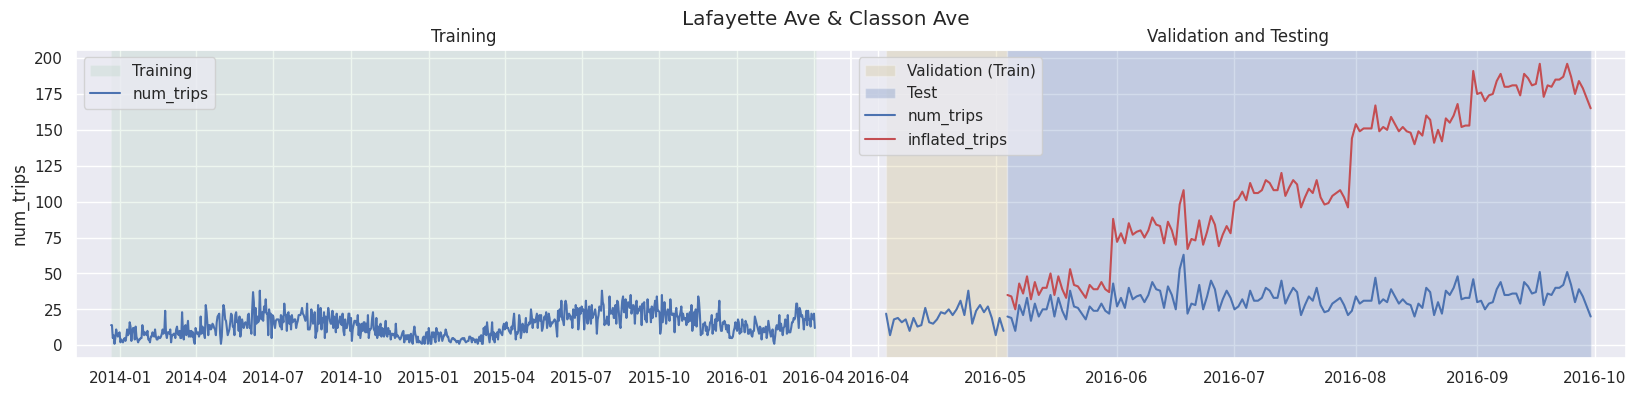

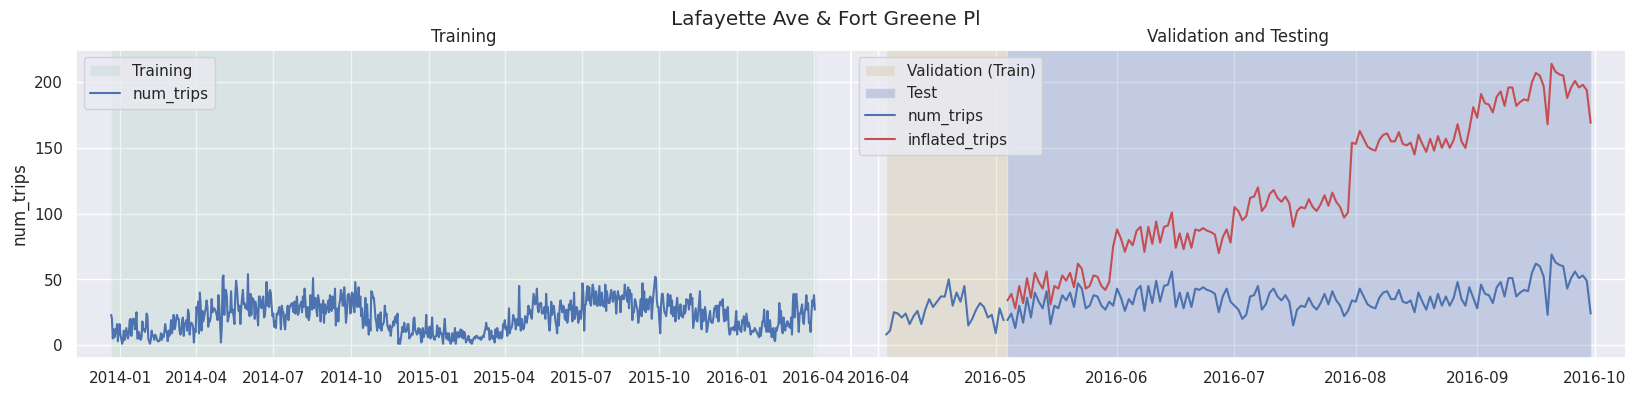

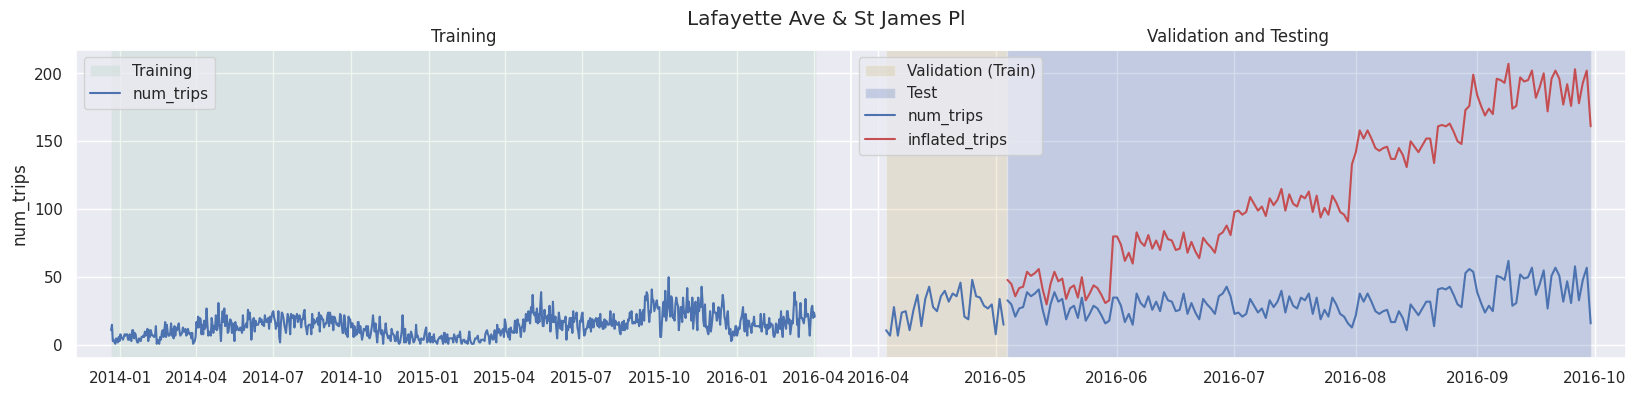

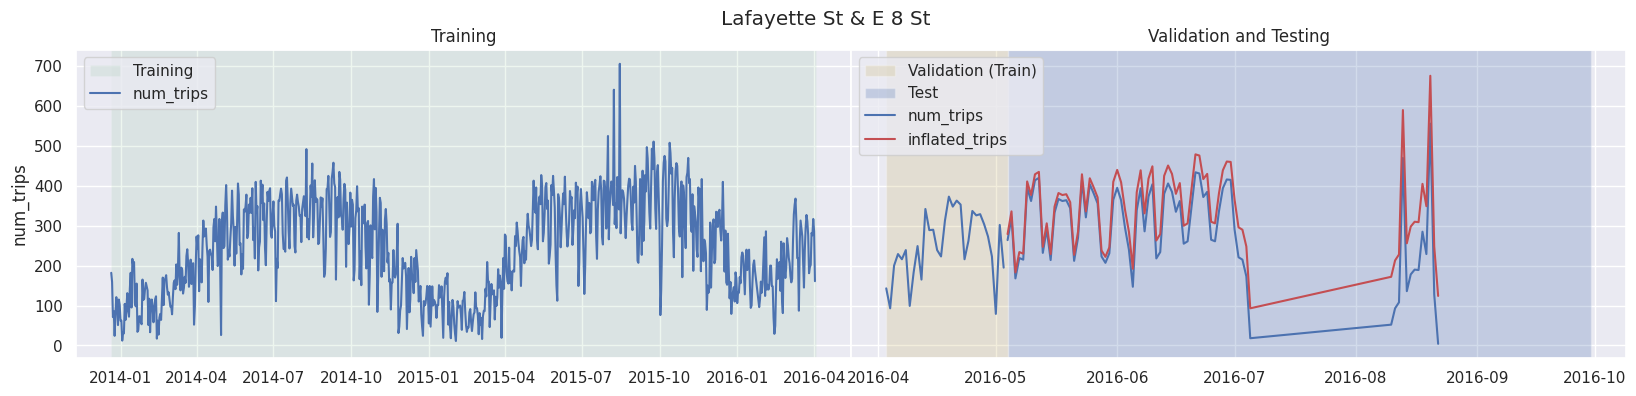

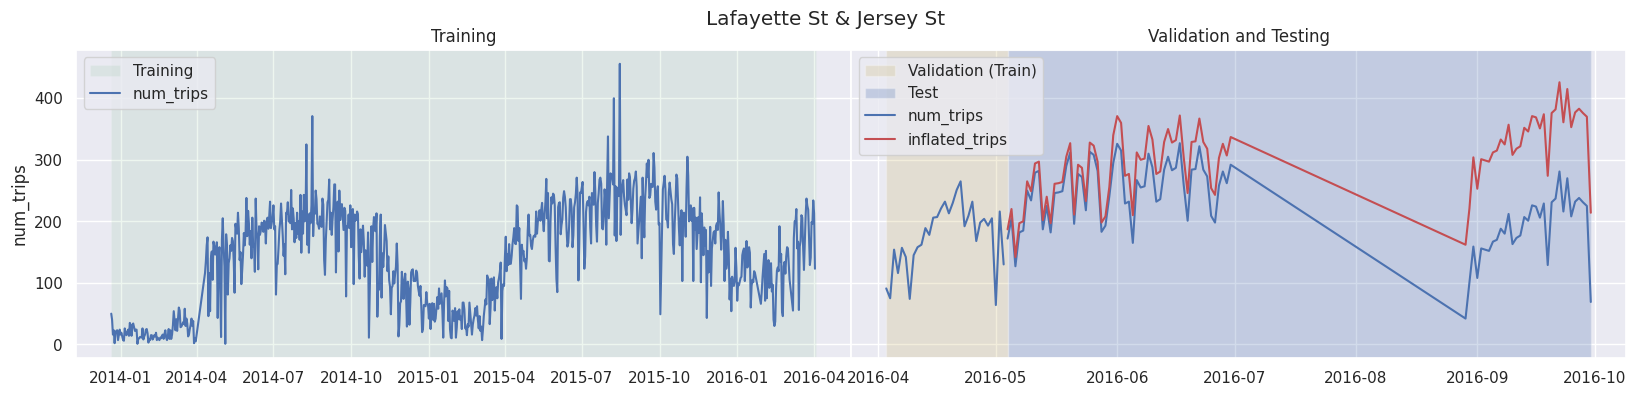

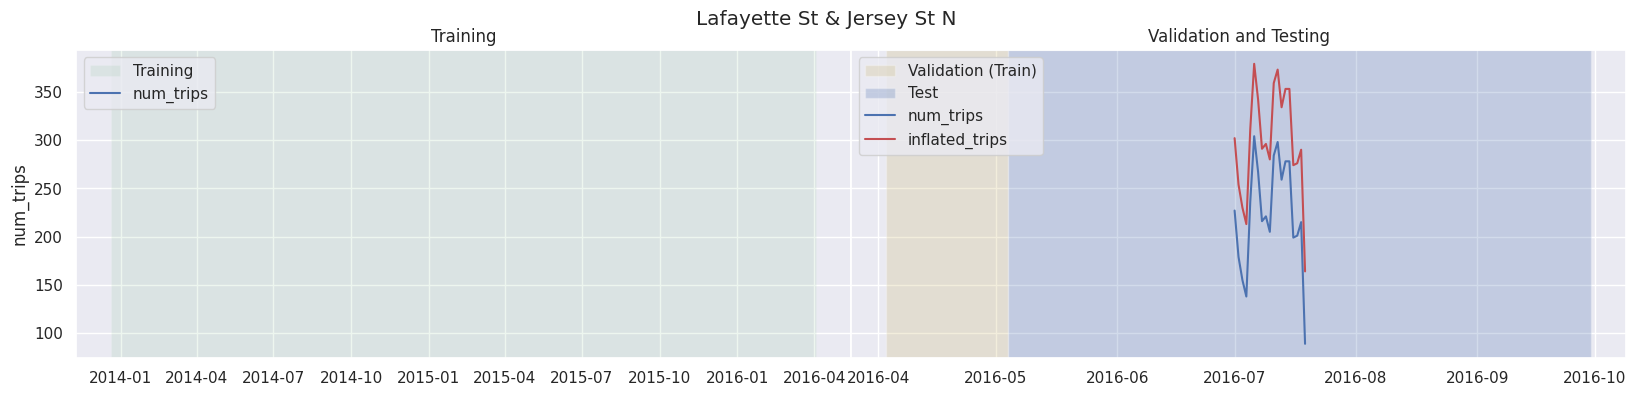

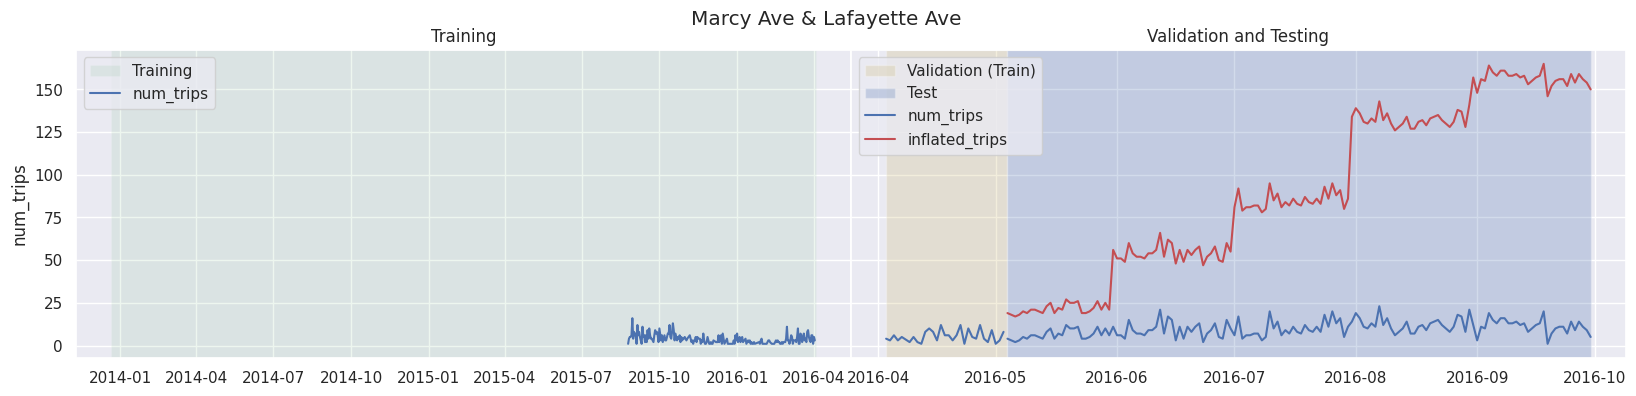

In [47]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')
        axes[1].plot(testdf[TIME_COLUMN], testdf[INFLATED_TARGET], color = 'r', label = 'inflated_trips')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)
        # plt.axvline(x=rawSeries['starttime'] == TREATMENT_DATE, color='red')

        # display result
        plt.show()

In [48]:
NYC_STATION='Lafayette St & Jersey St'

rawSeries_nyc_1 = rawSeries.loc[rawSeries['start_station_name'] == NYC_STATION]
rawSeries_nyc_1

,start_station_name,starttime,num_trips,num_trips_jt,splits,control_group,avg_tripduration,pct_subscriber,ratio_gender,capacity
5953,Lafayette St & Jersey St,2013-12-21,50,50,TRAIN,0,653.560000,0.960000,2.571429,60
5954,Lafayette St & Jersey St,2013-12-22,40,40,TRAIN,0,530.000000,0.975000,2.636364,60
5955,Lafayette St & Jersey St,2013-12-23,16,16,TRAIN,0,649.062500,0.875000,4.333333,60
5956,Lafayette St & Jersey St,2013-12-24,23,23,TRAIN,0,818.000000,0.913043,2.285714,60
5957,Lafayette St & Jersey St,2013-12-25,2,2,TRAIN,0,236.000000,1.000000,0.000000,60
...,...,...,...,...,...,...,...,...,...,...
6883,Lafayette St & Jersey St,2016-09-26,232,377,TEST,1,735.474138,0.922414,2.362319,60
6884,Lafayette St & Jersey St,2016-09-27,238,383,TEST,1,760.726891,0.924370,1.975000,60
6885,Lafayette St & Jersey St,2016-09-28,231,376,TEST,1,637.714286,0.948052,2.553846,60
6886,Lafayette St & Jersey St,2016-09-29,225,370,TEST,1,646.822222,0.955556,2.750000,60


In [49]:
from datetime import datetime

TREATMENT_DATE_obj = datetime.strptime(TREATMENT_DATE, '%Y-%m-%d').date()

rawSeries_nyc_1.reset_index(inplace=True)

rawSeries_nyc_1.loc[rawSeries_nyc_1['starttime'] == TREATMENT_DATE_obj]

,index,start_station_name,starttime,num_trips,num_trips_jt,splits,control_group,avg_tripduration,pct_subscriber,ratio_gender,capacity
844,6797,Lafayette St & Jersey St,2016-05-04,172,187,TEST,1,675.273256,0.930233,3.095238,60


In [50]:
rawSeries_nyc_1.set_index(TIME_COLUMN, inplace=True)

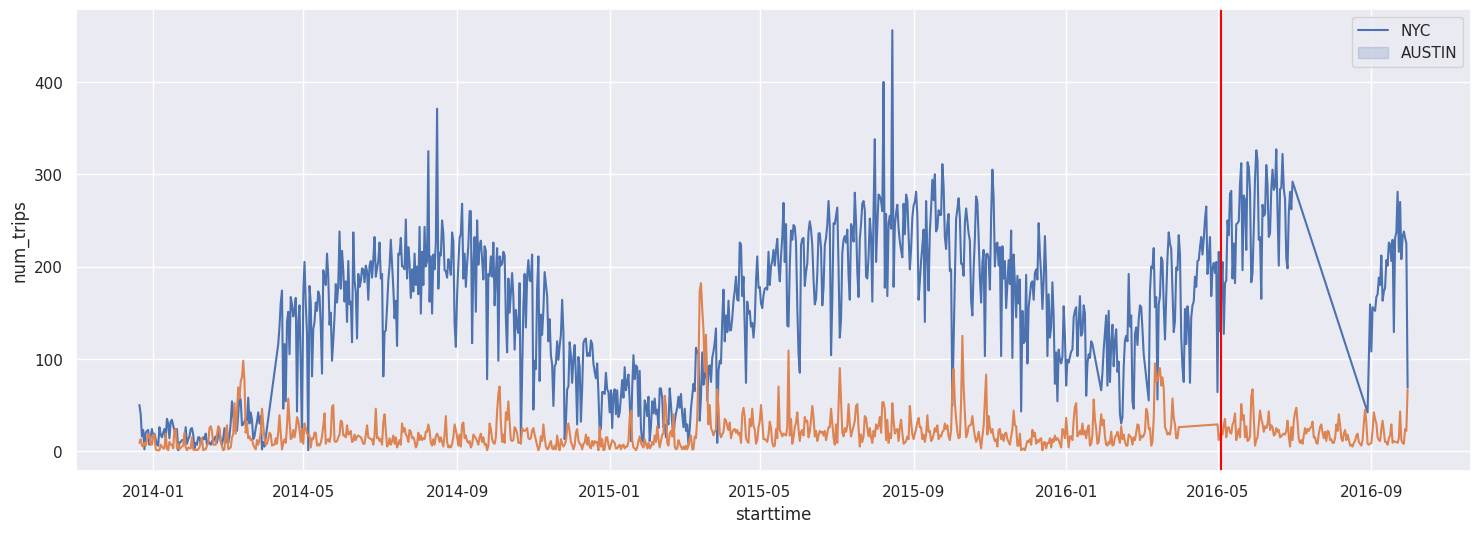

In [53]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(18,6)})
sns.lineplot(x=rawSeries_nyc_1.index, y=rawSeries_nyc_1[TARGET_COLUMN])
# sns.lineplot(x=rawSeries_nyc_1.index, y=rawSeries_nyc_1[INFLATED_TARGET])
sns.lineplot(x=rawSeries_austin_2.index, y=rawSeries_austin_2['num_trips'])
plt.axvline(x= rawSeries_nyc_1.index[844], color='red')
plt.legend(labels = ['NYC', 'AUSTIN']);

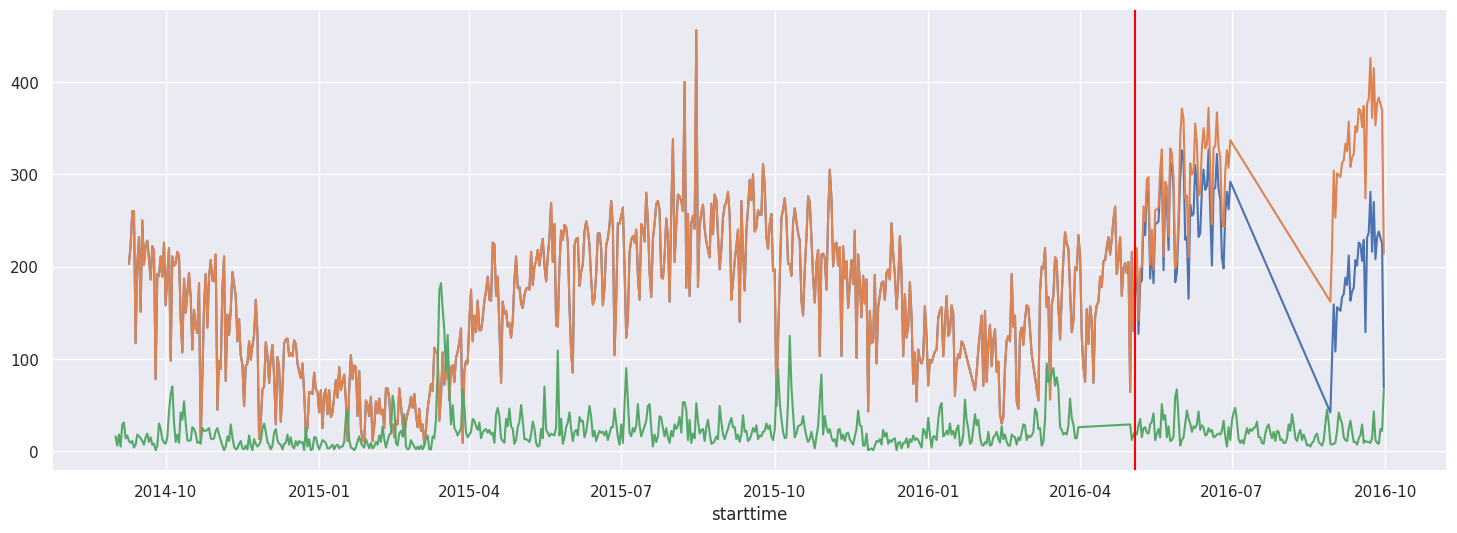

In [52]:
rawSeries_nyc_1[TARGET_COLUMN][250:].plot()
rawSeries_nyc_1[INFLATED_TARGET][250:].plot()
rawSeries_austin_2[TARGET_COLUMN][250:].plot()
plt.axvline(x=rawSeries_austin_2.index[826], color='red')
pyplot.show()